# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

Цель работы:

Построить модель, которая умеет определять рыночную стоимость автомобиля.

План работы:

- Загрузить данные.
- Изучить данные. Заполнить пропущенные значения и обработать аномалии в столбцах. Если среди признаков имеются неинформативные, удалить их.
- Подготовить выборки для обучения моделей.
- Обучить разные модели, одна из которых — LightGBM, как минимум одна — не бустинг. Для каждой модели попробовать разные гиперпараметры.
- Проанализировать время обучения, время предсказания и качество моделей.
- Опираясь на критерии заказчика, выбрать лучшую модель, проверить её качество на тестовой выборке.

Описание данных:

Признаки:

DateCrawled — дата скачивания анкеты из базы

VehicleType — тип автомобильного кузова

RegistrationYear — год регистрации автомобиля

Gearbox — тип коробки передач

Power — мощность (л. с.)

Model — модель автомобиля

Kilometer — пробег (км)

RegistrationMonth — месяц регистрации автомобиля

FuelType — тип топлива

Brand — марка автомобиля

Repaired — была машина в ремонте или нет

DateCreated — дата создания анкеты

NumberOfPictures — количество фотографий автомобиля

PostalCode — почтовый индекс владельца анкеты (пользователя)

LastSeen — дата последней активности пользователя

Целевой признак:

Price — цена (евро)

In [1]:
!pip install scikit-learn==1.1.3
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error

## Подготовка данных

In [2]:
pth1 = '/datasets/autos.csv'
pth2 = 'https://code.s3.yandex.net/datasets/autos.csv'

if os.path.exists(pth1):
    data= pd.read_csv(pth1)
elif os.path.exists(pth2):
    data= pd.read_csv(pth2)
else:
    print('Something is wrong')
    
display(data.head())
data.info()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [3]:
# приведем названия стобцов к нижнему регистру:
data.columns = data.columns.str.lower()

In [4]:
# приведем в порядок названия столбцов
data.rename(
    columns={
        'datecrawled':'date_crawled',
        'vehicletype':'vehicle_type',
        'registrationyear':'registration_year',
        'registrationmonth':'registration_month',
        'fueltype':'fuel_type',
        'datecreated':'date_created',
        'numberofpictures':'number_of_pictures',
        'postalcode':'postal_code',
        'lastseen':'last_seen'
    },
    inplace=True
)

In [5]:
# проверяем замены в названиях
display(data.head())

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [6]:
# проверяем наличие пропущенных значений в датафреймах
data.isna().sum()

date_crawled              0
price                     0
vehicle_type          37490
registration_year         0
gearbox               19833
power                     0
model                 19705
kilometer                 0
registration_month        0
fuel_type             32895
brand                     0
repaired              71154
date_created              0
number_of_pictures        0
postal_code               0
last_seen                 0
dtype: int64

In [7]:
# заменим пропуски в категориальных данных на unknown:
data['vehicle_type'] = data['vehicle_type'].fillna('unknown1')
data['gearbox'] = data['gearbox'].fillna('unknown2')
data['model'] = data['model'].fillna('unknown3')
data['fuel_type'] = data['fuel_type'].fillna('unknown4')
data['repaired'] = data['repaired'].fillna('unknown5')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   date_crawled        354369 non-null  object
 1   price               354369 non-null  int64 
 2   vehicle_type        354369 non-null  object
 3   registration_year   354369 non-null  int64 
 4   gearbox             354369 non-null  object
 5   power               354369 non-null  int64 
 6   model               354369 non-null  object
 7   kilometer           354369 non-null  int64 
 8   registration_month  354369 non-null  int64 
 9   fuel_type           354369 non-null  object
 10  brand               354369 non-null  object
 11  repaired            354369 non-null  object
 12  date_created        354369 non-null  object
 13  number_of_pictures  354369 non-null  int64 
 14  postal_code         354369 non-null  int64 
 15  last_seen           354369 non-null  object
dtypes:

In [8]:
# изменим тип данных столбцов с датами и временем на datetime
data['date_crawled'] = pd.to_datetime(data['date_crawled'])
data['date_created'] = pd.to_datetime(data['date_created'])
data['last_seen'] = pd.to_datetime(data['last_seen'])

In [9]:
data.describe(include='datetime')

/tmp/ipykernel_204/1602202450.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  data.describe(include='datetime')
/tmp/ipykernel_204/1602202450.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  data.describe(include='datetime')
/tmp/ipykernel_204/1602202450.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  data.describe(include='datetime')


,date_crawled,date_created,last_seen
count,354369,354369,354369
unique,271174,109,179150
top,2016-03-24 14:49:47,2016-04-03 00:00:00,2016-04-06 13:45:54
freq,7,13719,17
first,2016-03-05 14:06:22,2014-03-10 00:00:00,2016-03-05 14:15:08
last,2016-04-07 14:36:58,2016-04-07 00:00:00,2016-04-07 14:58:51


Анкеты созданы с 2014 по 2016 гг. 

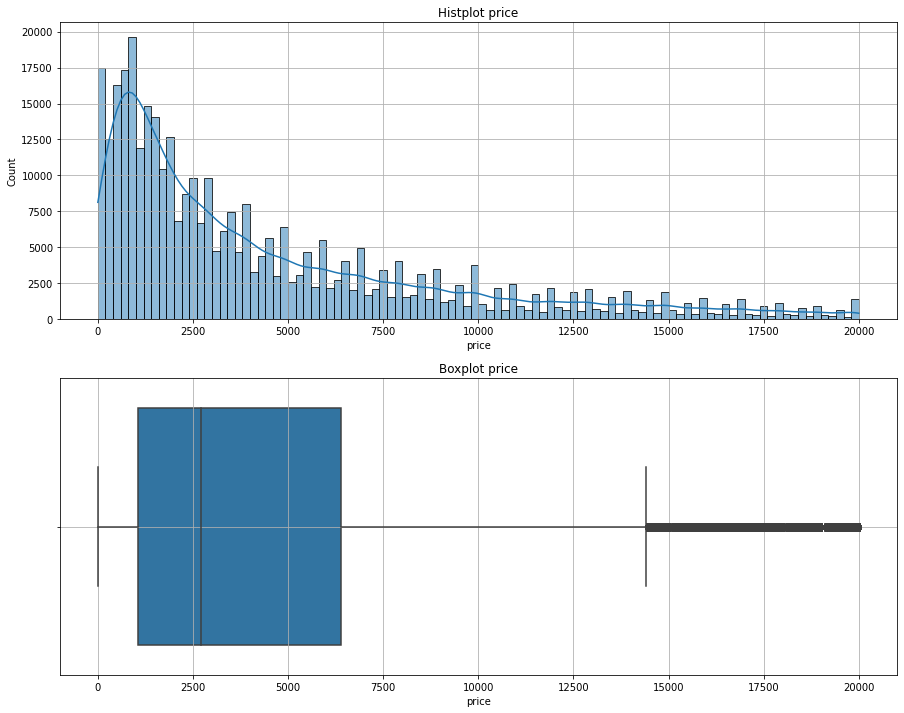

                   count   percent
registration_year                 
2000               24490  6.910875
1999               22728  6.413654
2005               22109  6.238977
2001               20124  5.678826
2006               19900  5.615615
...                  ...       ...
2900                   1  0.000282
3200                   1  0.000282
3500                   1  0.000282
3700                   1  0.000282
1255                   1  0.000282

[151 rows x 2 columns]


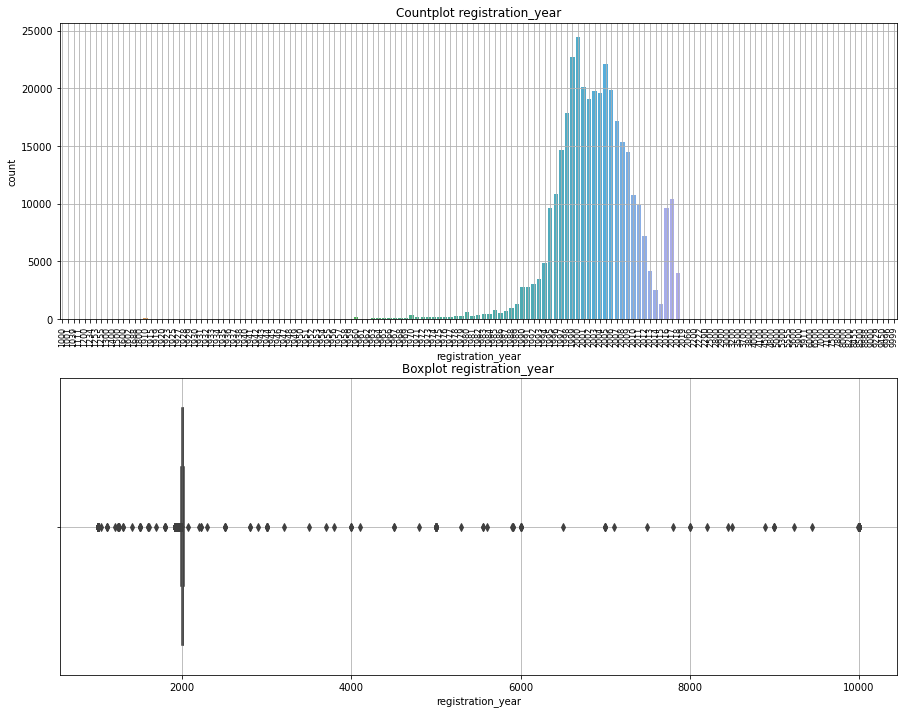

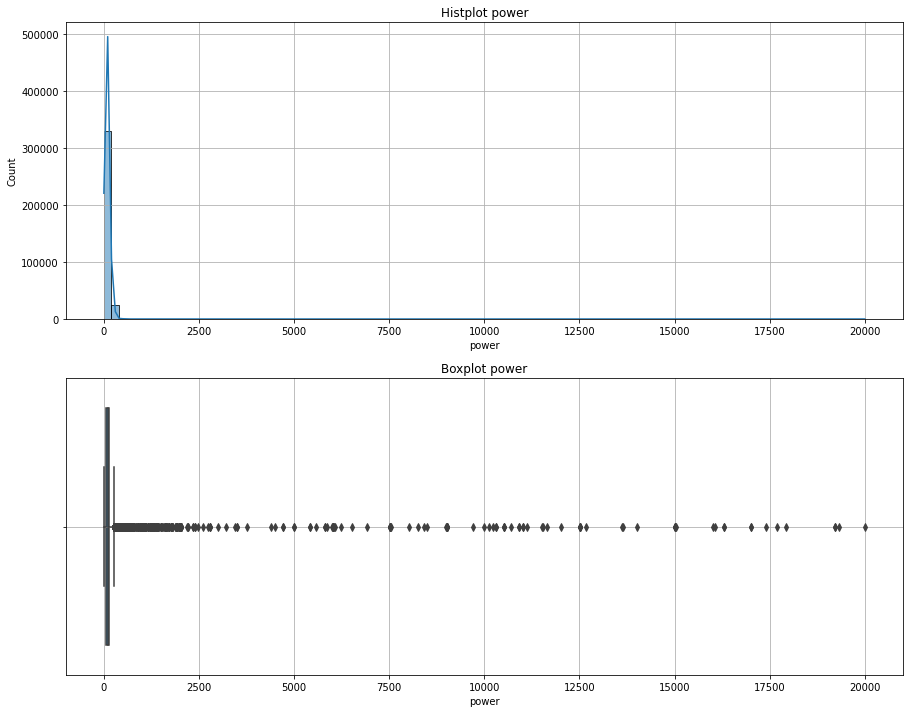

            count    percent
kilometer                   
150000     238209  67.220609
125000      36454  10.287017
100000      14882   4.199577
90000       11567   3.264112
80000       10047   2.835180
70000        8593   2.424874
60000        7444   2.100635
5000         6397   1.805180
50000        6232   1.758619
40000        4911   1.385844
30000        4436   1.251802
20000        3975   1.121712
10000        1222   0.344838


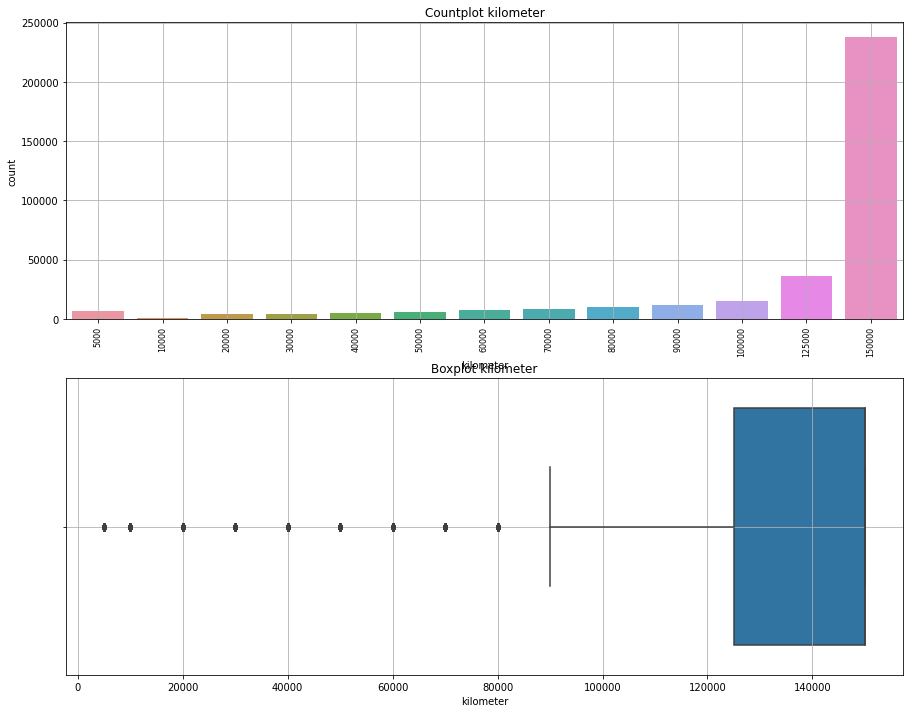

                    count    percent
registration_month                  
0                   37352  10.540425
3                   34373   9.699776
6                   31508   8.891297
4                   29270   8.259752
5                   29153   8.226735
7                   27213   7.679283
10                  26099   7.364922
12                  24289   6.854155
11                  24186   6.825089
9                   23813   6.719832
1                   23219   6.552210
8                   22627   6.385152
2                   21267   6.001371


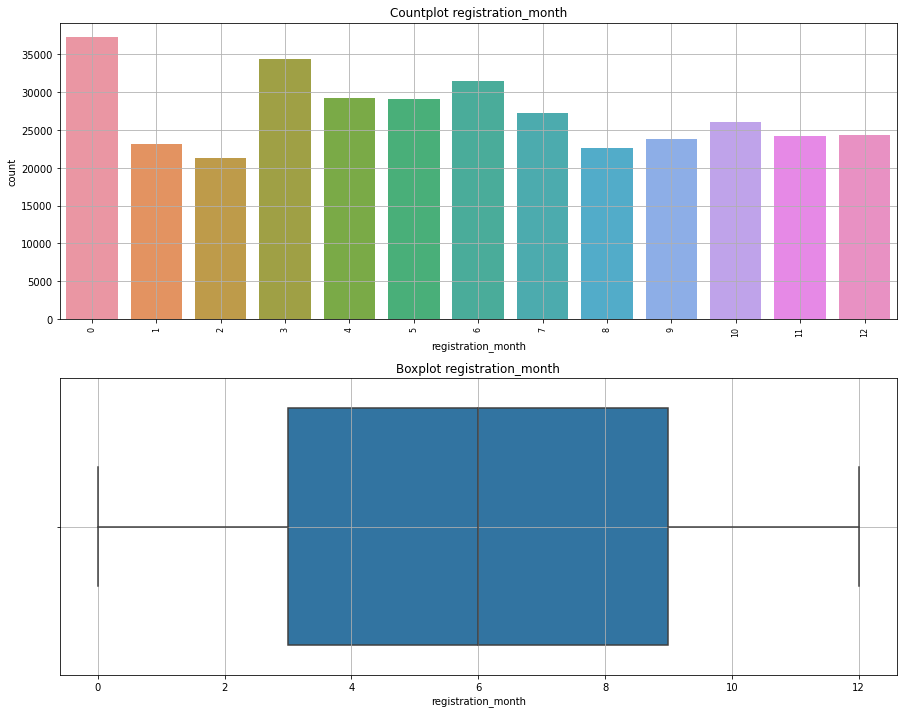

                     count  percent
number_of_pictures                 
0                   354369    100.0


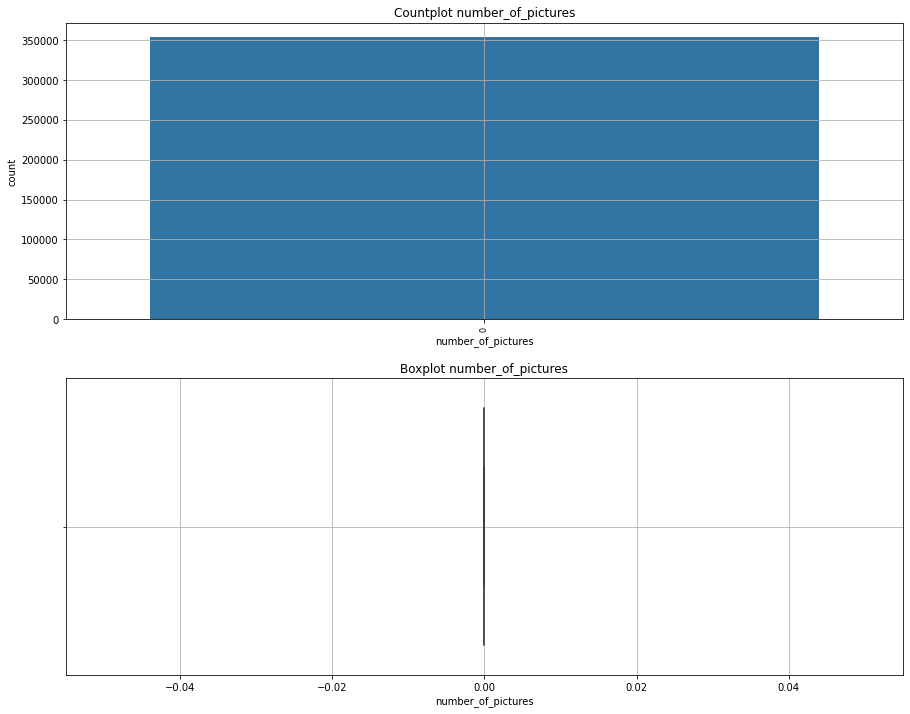

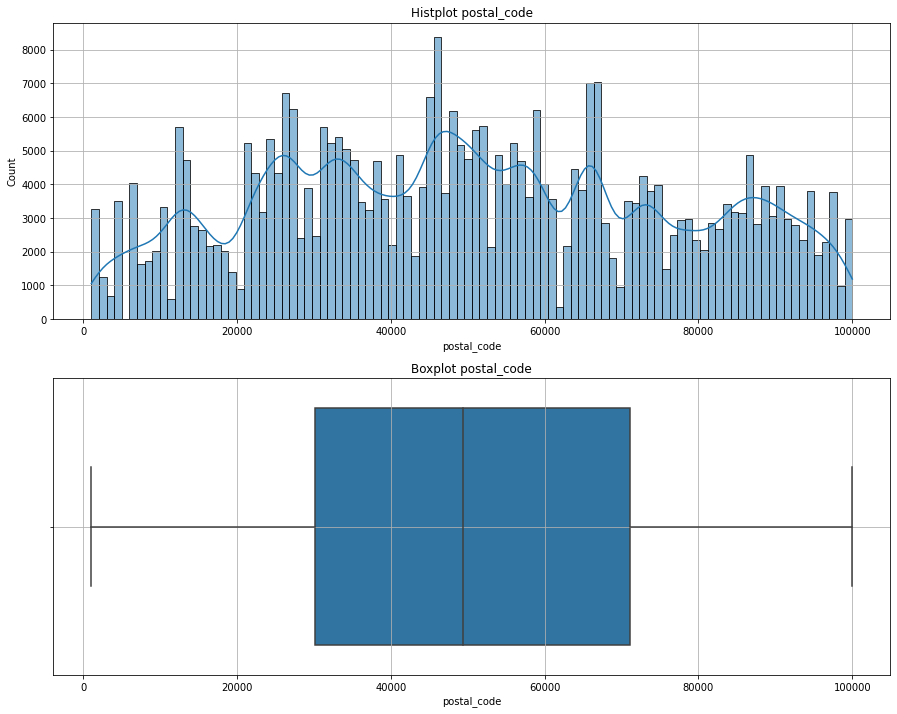

In [10]:
# проведем анализ числовых значений датафрейма
continuous_col = ['price', 'power', 'postal_code']
discrete_col = ['kilometer', 'number_of_pictures', 'registration_year', 'registration_month']

for col in data.select_dtypes(include='number').columns:

    plt.figure(figsize=(15,12))
    plt.subplot(2,1,1)
    if col in continuous_col:
        sns.histplot(data=data[col], kde=True, bins=100)
        plt.grid()
        plt.title('Histplot '+col)
    else:
        print(data.groupby(col)[col].agg(['count']).assign(percent=lambda x: x / x.sum() * 100).
                                    sort_values('count', ascending=False))
        sns.countplot(data=data, x=col)
        plt.grid()
        plt.title('Countplot '+col)
        plt.xticks(rotation=90, fontsize=8)
    plt.subplot(2,1,2)
    sns.boxplot(data=data, x=col)
    plt.grid()
    plt.title('Boxplot '+col)
    
    plt.show()

Цена меняется от нуля до 20 тысяч, а медианное значение составляет примерно 2700. Возможно, нулевые значения являются ошибкой в данных и их можно удалить.

In [11]:
# посчитаем процент объектов с нулевым значением цены
data[data['price'] == 0]['price'].count() / data.shape[0] * 100

3.0397692800442475

In [12]:
# посчитаем процент объектов c ценой менее 200 евро
data[data['price'] < 200]['price'].count() / data.shape[0] * 100

4.927631931687026

In [13]:
data = data.query('price > 200')

Автомобили, зарегистрированные после 2016 года, - это ошибочные данные. Имеются явно ошибочные данные со значениями менее 1900.

In [14]:
# посчитаем процент объектов с датой регистрации ранее 1900 г и позже 2016 года
data[(data['registration_year'] < 1900) | (data['registration_year'] > 2016)]['price'].count() / data.shape[0] * 100

4.064839171028392

In [15]:
# удалим данные по году регистрации до 1900 года и после 2016:
data = data.query('registration_year > 1900 & registration_year < 2016')
np.sort(data['registration_year'].unique())

array([1910, 1923, 1925, 1927, 1928, 1929, 1930, 1931, 1932, 1933, 1934,
       1935, 1936, 1937, 1938, 1940, 1941, 1942, 1943, 1944, 1945, 1946,
       1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957,
       1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968,
       1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979,
       1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990,
       1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001,
       2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012,
       2013, 2014, 2015])

In [16]:
# добавим столбец с группировкой данных по возврасту
def age(registration_year):
    if registration_year < 1930:
        return 'vintage'
    if registration_year < 1960:
        return 'superretro'
    if registration_year < 1980:
        return 'retro'
    if registration_year < 2000:
        return 'classic'
    if registration_year < 2016:
        return 'ordinary'
    else:
        return 'unknown'
    return registration_year

data['age_group'] = data['registration_year'].apply(age)

Мощности автомобилей в данных меняются от нуля до 20 000 л.с, часть данных явно ошибочно заполнена.

In [17]:
# посчитаем процент объектов с мощностью более 1000 л.с.
data[data['power'] > 1000]['price'].count() / data.shape[0] * 100

0.07700197137827139

In [18]:
# посчитаем процент объектов с мощностью менее 1 л.с.
data[data['power'] < 1]['price'].count() / data.shape[0] * 100

8.729020157901967

In [19]:
# удалим данные по мощности более 1000
data = data.query('power < 1000')

              count    percent
vehicle_type                  
sedan         88180  28.196396
small         74671  23.876765
wagon         62836  20.092411
bus           28149   9.000911
convertible   19748   6.314611
coupe         15354   4.909588
suv           11732   3.751419
unknown1       9100   2.909812
other          2965   0.948087


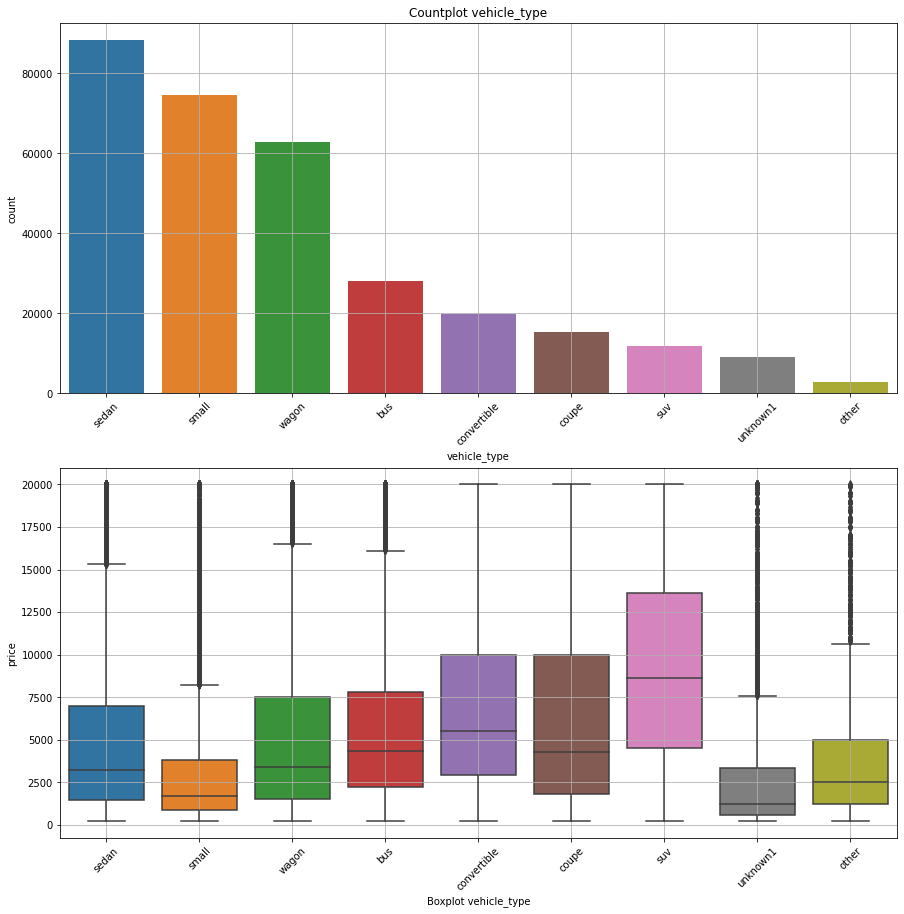

           count    percent
gearbox                    
manual    238691  76.323725
auto       61557  19.683438
unknown2   12487   3.992837


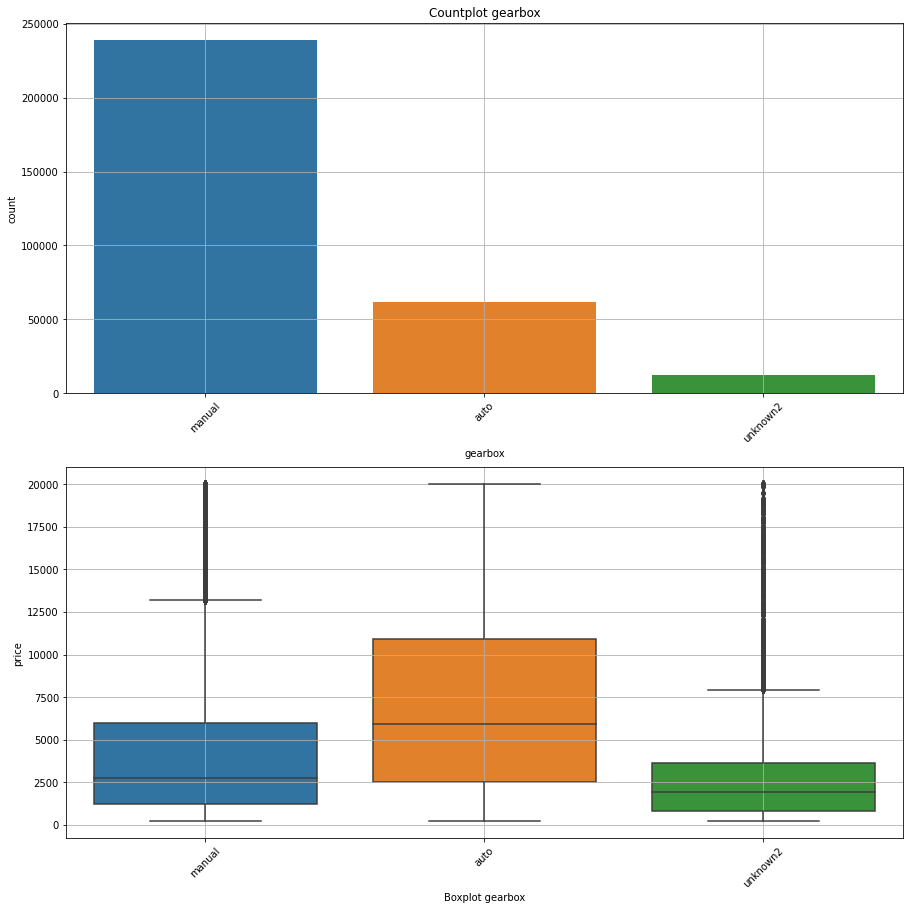

                    count   percent
model                              
golf                25169  8.048028
other               22223  7.106016
3er                 18166  5.808752
unknown3            13372  4.275825
polo                10941  3.498489
...                   ...       ...
elefantino              4  0.001279
rangerover              3  0.000959
serie_3                 3  0.000959
range_rover_evoque      2  0.000640
serie_1                 1  0.000320

[251 rows x 2 columns]


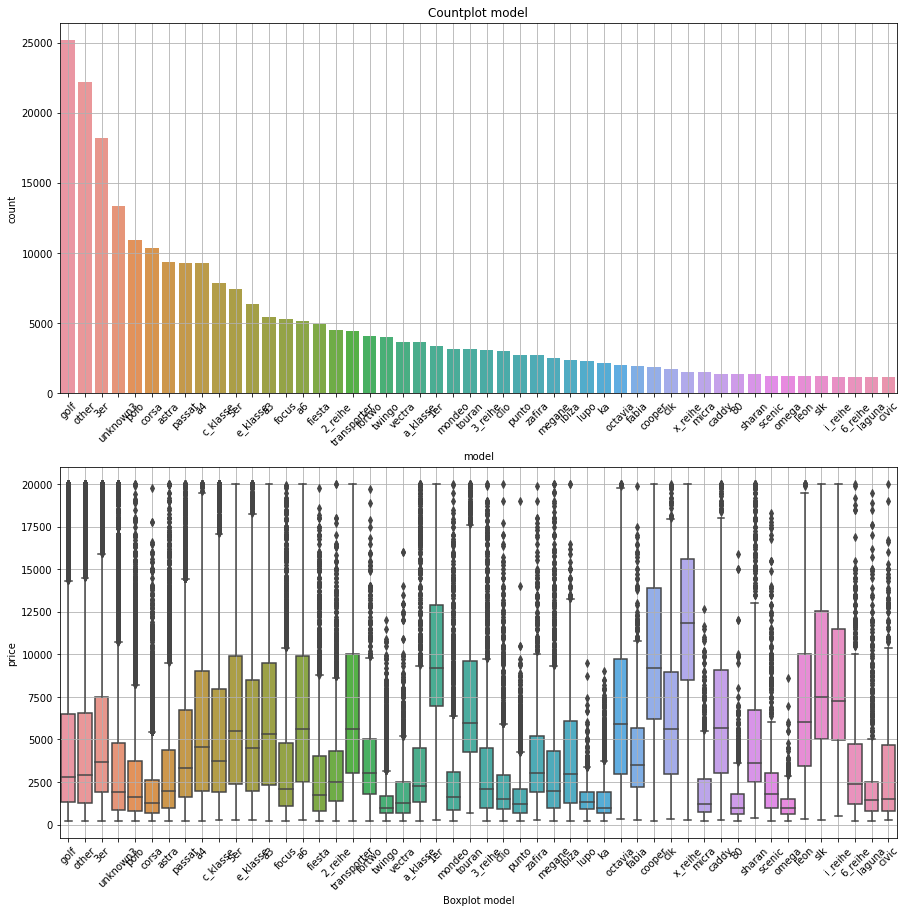

            count    percent
fuel_type                   
petrol     195239  62.429533
gasoline    93249  29.817257
unknown4    18396   5.882297
lpg          4909   1.569700
cng           515   0.164676
hybrid        212   0.067789
other         133   0.042528
electric       82   0.026220


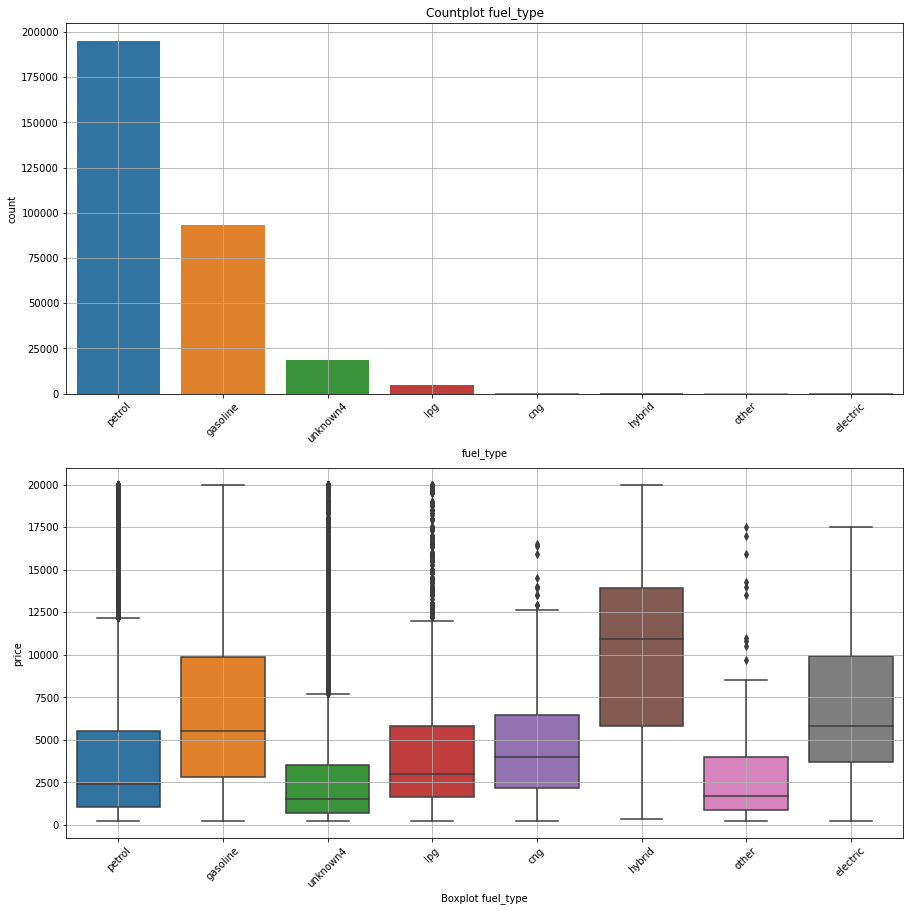

                count    percent
brand                           
volkswagen      66885  21.387117
bmw             33808  10.810431
opel            33787  10.803716
mercedes_benz   29550   9.448894
audi            26829   8.578829
ford            21593   6.904568
renault         15096   4.827090
peugeot          9914   3.170096
fiat             8199   2.621708
seat             5989   1.915040
skoda            5171   1.653477
mazda            4983   1.593362
smart            4820   1.541241
citroen          4543   1.452668
nissan           4345   1.389355
toyota           4295   1.373367
hyundai          3293   1.052968
mini             3018   0.965034
volvo            2958   0.945849
mitsubishi       2626   0.839689
sonstige_autos   2477   0.792044
honda            2475   0.791405
kia              2232   0.713703
suzuki           2059   0.658385
alfa_romeo       2046   0.654228
chevrolet        1622   0.518650
chrysler         1274   0.407374
dacia             849   0.271476
porsche   

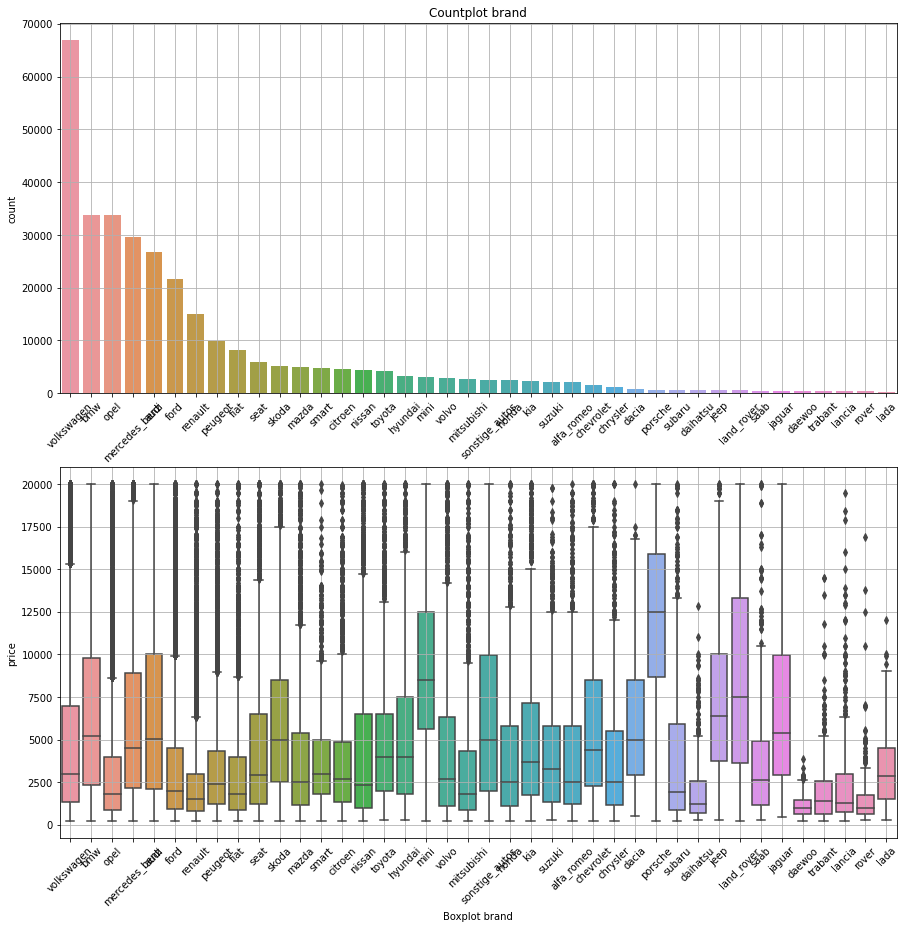

           count    percent
repaired                   
no        231649  74.071978
unknown5   51833  16.574096
yes        29253   9.353926


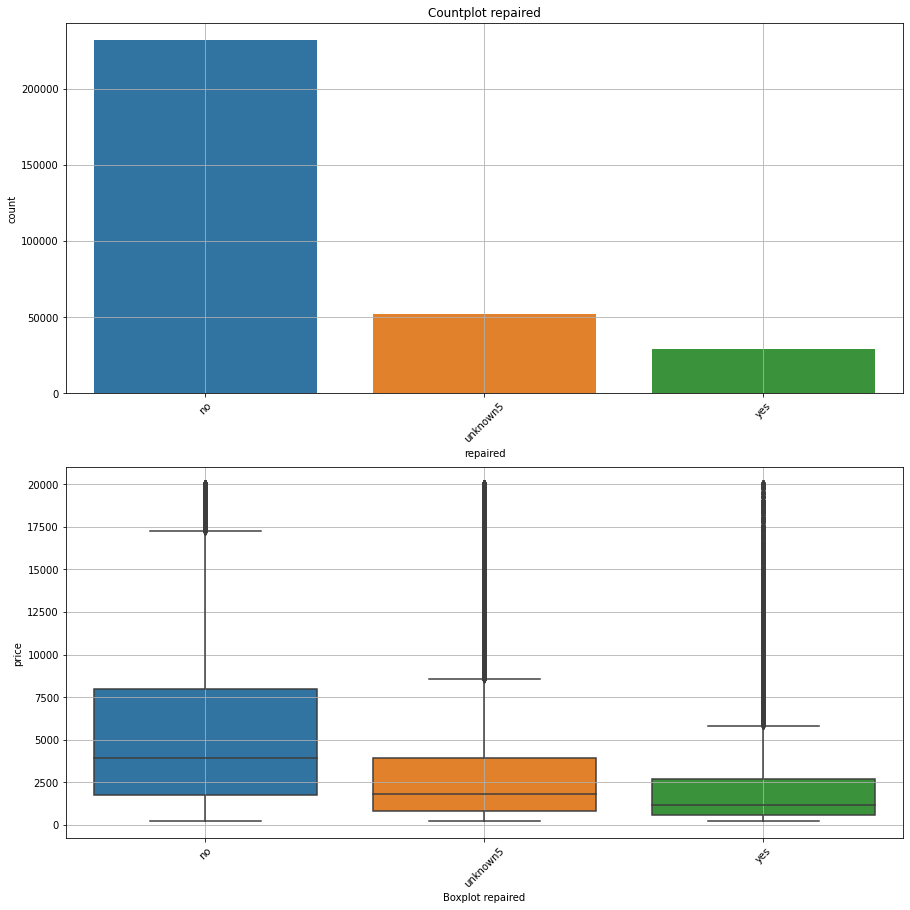

             count    percent
age_group                    
ordinary    221113  70.702991
classic      88639  28.343166
retro         2738   0.875502
superretro     208   0.066510
vintage         37   0.011831


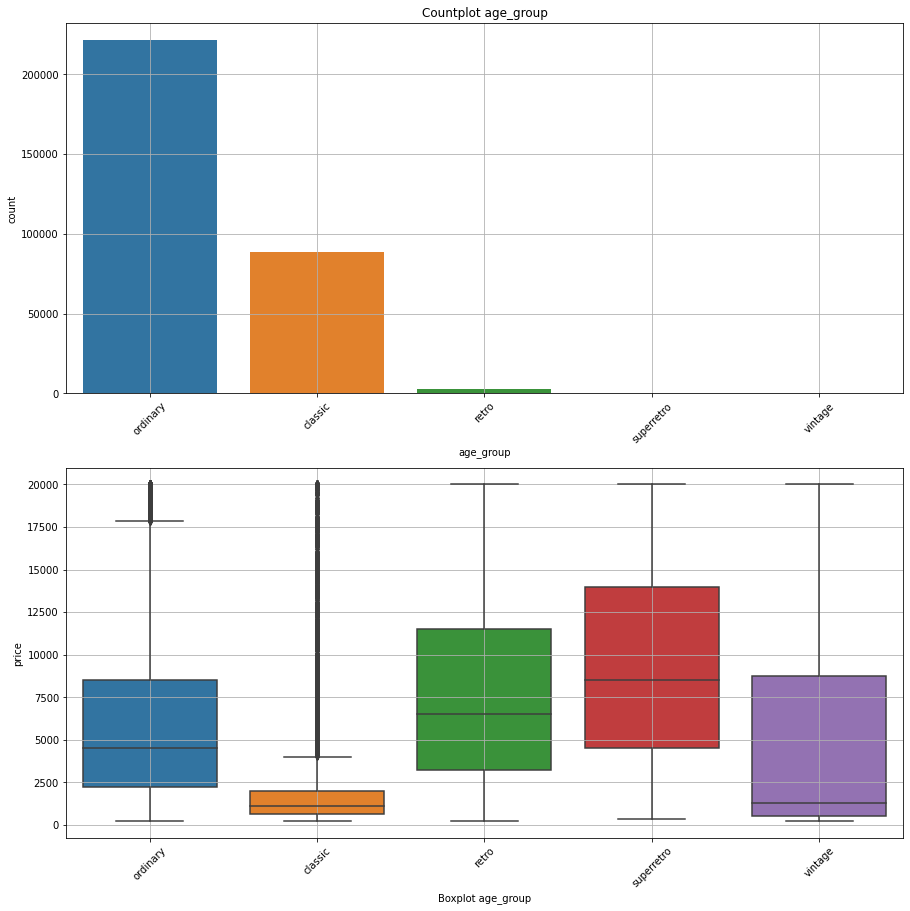

In [20]:
# рассмотрим категориальные признаки
for col in data.select_dtypes(include='object').columns:
    plt.figure(figsize=(15,15))
    plt.subplot(2,1,1)
    print(data.groupby(col)[col].agg(['count']).assign(percent=lambda x: x / x.sum() * 100).
                                    sort_values('count', ascending=False))
    sns.countplot(data = data, x = col, order = data[col].value_counts().index[:50])
    plt.grid()
    plt.title('Countplot '+col)
    plt.xticks(rotation=45)
    plt.subplot(2,1,2)
    sns.boxplot(data = data, x = col, y='price', order = data[col].value_counts().index[:50])
    plt.grid()
    plt.xticks(rotation=45)
    plt.xlabel('Boxplot '+col)

    plt.show()

In [21]:
# переименуем gasoline в petrol
data['fuel_type'] = data['fuel_type'].replace(['gasoline'],'petrol')

In [22]:
# проверяем наличие явных дубликатов в датафреймах
data.duplicated().sum()

4

In [23]:
# удалим дубликаты
data = data.drop_duplicates().reset_index(drop = True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 312731 entries, 0 to 312730
Data columns (total 17 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_crawled        312731 non-null  datetime64[ns]
 1   price               312731 non-null  int64         
 2   vehicle_type        312731 non-null  object        
 3   registration_year   312731 non-null  int64         
 4   gearbox             312731 non-null  object        
 5   power               312731 non-null  int64         
 6   model               312731 non-null  object        
 7   kilometer           312731 non-null  int64         
 8   registration_month  312731 non-null  int64         
 9   fuel_type           312731 non-null  object        
 10  brand               312731 non-null  object        
 11  repaired            312731 non-null  object        
 12  date_created        312731 non-null  datetime64[ns]
 13  number_of_pictures  312731 no

In [24]:
# удалим столбцы date_crawled, date_created, last_seen, number_of_pictures, т.к. эти данные не влияют на стоимость автомобиля
data = data.drop(['date_crawled', 'date_created', 'last_seen', 'number_of_pictures', 'registration_year'], axis=1)

In [25]:
data.shape

(312731, 12)

Выводы:

В датафрейме data 354369 записей, названия столбцов адекватны содержащимся в них данным. Названия столбцов были отредактированы. Было проверено, нет ли пропущенных значений, для категориальных данных пропуски заменены на unknown. Было проверено наличие явных и неявных дубликатов, 4 дубликата были удалены. Отдельно рассмотрены числовые и категориальные данные.  Цена меняется от нуля до 20 тысяч, а медианное значение составляет примерно 2700. Возможно, нулевые и околонулевые значения являются ошибкой в данных и их можно удалить. Удалены записи с registration_year до 1900 года и после 2016. Мощности автомобилей в данных меняются от нуля до 20 000 л.с, часть данных явно ошибочно заполнена, удалены записи с мощностью более 1000. В столбце тип топлива gasoline переименовали  petrol. Столбцы date_crawled, date_created, last_see, number_of_pictures никак не влияют на стоимость автомобиля, поэтому было принято решение удалить столбцы. Данные готовы к обучению моделей.

## Обучение моделей

Кодирование категориальных признаков OneHotEncoder для LinearRegression

In [26]:
data_ohe = pd.get_dummies(data, drop_first = True)
features_ohe = data_ohe.drop('price',axis=1)
target_ohe = data_ohe['price']

x_train_ohe, x_temp, y_train_ohe, y_temp = train_test_split(\
                                                    features_ohe, target_ohe,\
                                                    test_size=.3, random_state=12345)
x_test_ohe, x_valid_ohe, y_test_ohe, y_valid_ohe = train_test_split(\
                                                    x_temp, y_temp,\
                                                    test_size=.5, random_state=12345)

Кодирование категориальных признаков Ordinal Encoder (OE) для DecisionTreeRegressor, RandomForestRegressor и LightGBM

In [27]:
# Определяем категориальные признаки
categorical_features = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired', 'age_group']
kol = list((set(data.columns) - set(['price'])) - set(categorical_features))

data = data.reset_index(drop=True)

# Разделение признаков и целевой переменной
features = data.drop('price', axis=1)
target = data['price']

# Разбиение данных на обучающую и временную выборки
x_train, x_temp, y_train, y_temp = train_test_split(
    features, target, test_size=0.3, random_state=12345)
x_test, x_valid, y_test, y_valid = train_test_split(
    x_temp, y_temp, test_size=0.5, random_state=12345)

# Кодировка категориальных признаков
enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

# Применение fit_transform только к обучающим данным
temp_0_train = x_train[categorical_features]
temp_train = enc.fit_transform(temp_0_train)
x_train_encoded = pd.DataFrame(data=temp_train, columns=temp_0_train.columns)

# Применение transform к валидационным и тестовым данным
temp_0_valid = x_valid[categorical_features]
temp_valid = enc.transform(temp_0_valid)
x_valid_encoded = pd.DataFrame(data=temp_valid, columns=temp_0_valid.columns)

temp_0_test = x_test[categorical_features]
temp_test = enc.transform(temp_0_test)
x_test_encoded = pd.DataFrame(data=temp_test, columns=temp_0_test.columns)

# Объединяем закодированные признаки с остальными признаками
x_train = pd.concat([x_train_encoded, x_train[kol].reset_index(drop=True)], axis=1)
x_valid = pd.concat([x_valid_encoded, x_valid[kol].reset_index(drop=True)], axis=1)
x_test = pd.concat([x_test_encoded, x_test[kol].reset_index(drop=True)], axis=1)

# Масштабирование данных
scaler = StandardScaler()
x_train = pd.DataFrame(data=scaler.fit_transform(x_train), columns=x_train.columns)
x_valid = pd.DataFrame(data=scaler.transform(x_valid), columns=x_valid.columns)
x_test = pd.DataFrame(data=scaler.transform(x_test), columns=x_test.columns)

In [28]:
# Масштабирование данных
scaler = StandardScaler()
x_train = pd.DataFrame(data=scaler.fit_transform(x_train), columns=features.columns)
x_test = pd.DataFrame(data=scaler.transform(x_test), columns=features.columns)
x_valid = pd.DataFrame(data=scaler.transform(x_valid), columns=features.columns)

# подготовим данные
column_all_ohe = features_ohe.columns
column_all = features.columns
column_all_ohe

Index(['power', 'kilometer', 'registration_month', 'postal_code',
       'vehicle_type_convertible', 'vehicle_type_coupe', 'vehicle_type_other',
       'vehicle_type_sedan', 'vehicle_type_small', 'vehicle_type_suv',
       ...
       'brand_toyota', 'brand_trabant', 'brand_volkswagen', 'brand_volvo',
       'repaired_unknown5', 'repaired_yes', 'age_group_ordinary',
       'age_group_retro', 'age_group_superretro', 'age_group_vintage'],
      dtype='object', length=315)

In [29]:
# масштабирование
scaler_ohe = StandardScaler()
x_train_ohe = pd.DataFrame(data = scaler_ohe.fit_transform(x_train_ohe), columns = column_all_ohe)
x_test_ohe =  pd.DataFrame(data = scaler_ohe.transform(x_test_ohe), columns = column_all_ohe)
x_valid_ohe = pd.DataFrame(data = scaler_ohe.transform(x_valid_ohe), columns = column_all_ohe)
x_valid_ohe

,power,kilometer,registration_month,postal_code,vehicle_type_convertible,vehicle_type_coupe,vehicle_type_other,vehicle_type_sedan,vehicle_type_small,vehicle_type_suv,...,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo,repaired_unknown5,repaired_yes,age_group_ordinary,age_group_retro,age_group_superretro,age_group_vintage
0,1.164361,0.587976,-0.249620,-0.596448,-0.259425,-0.226906,-0.097275,-0.625616,-0.560462,-0.19782,...,-0.118927,-0.037414,-0.522824,-0.098037,2.239537,-0.321799,0.644946,-0.093793,-0.025834,-0.011106
1,-0.130287,0.587976,-1.072617,0.631021,-0.259425,-0.226906,-0.097275,-0.625616,-0.560462,-0.19782,...,-0.118927,-0.037414,-0.522824,-0.098037,-0.446521,-0.321799,0.644946,-0.093793,-0.025834,-0.011106
2,-1.776568,0.587976,-1.072617,-0.837392,-0.259425,-0.226906,-0.097275,-0.625616,-0.560462,-0.19782,...,-0.118927,-0.037414,-0.522824,-0.098037,2.239537,-0.321799,-1.550517,-0.093793,-0.025834,-0.011106
3,0.780761,-0.084666,1.122042,1.897230,-0.259425,-0.226906,-0.097275,-0.625616,-0.560462,-0.19782,...,-0.118927,-0.037414,-0.522824,-0.098037,-0.446521,-0.321799,0.644946,-0.093793,-0.025834,-0.011106
4,-0.162254,0.587976,-1.621281,1.614362,-0.259425,-0.226906,-0.097275,-0.625616,-0.560462,-0.19782,...,-0.118927,-0.037414,-0.522824,-0.098037,-0.446521,-0.321799,-1.550517,-0.093793,-0.025834,-0.011106
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46905,-0.098321,-1.295420,-0.523952,0.832060,-0.259425,-0.226906,-0.097275,-0.625616,-0.560462,-0.19782,...,-0.118927,-0.037414,1.912688,-0.098037,-0.446521,-0.321799,0.644946,-0.093793,-0.025834,-0.011106
46906,-1.776568,0.587976,-1.621281,-0.326856,-0.259425,-0.226906,-0.097275,1.598425,-0.560462,-0.19782,...,-0.118927,-0.037414,-0.522824,-0.098037,-0.446521,-0.321799,0.644946,-0.093793,-0.025834,-0.011106
46907,3.721690,0.587976,0.847709,1.397679,-0.259425,-0.226906,-0.097275,-0.625616,-0.560462,-0.19782,...,-0.118927,-0.037414,-0.522824,-0.098037,-0.446521,-0.321799,0.644946,-0.093793,-0.025834,-0.011106
46908,-0.577820,0.587976,0.847709,-0.954351,-0.259425,-0.226906,-0.097275,-0.625616,1.784242,-0.19782,...,-0.118927,-0.037414,1.912688,-0.098037,-0.446521,-0.321799,-1.550517,-0.093793,-0.025834,-0.011106


Модель LinearRegression

In [30]:
model = LinearRegression()
model.fit(x_train_ohe, y_train_ohe)
#построим предсказания на тренировочной выборке
predictions_train_ohe = model.predict(x_train_ohe)
#найдем корень из квадратичной средней ошибки (RMSE)
rmse = mean_squared_error(y_train_ohe, predictions_train_ohe)**0.5
print(rmse)

2845.000195136076


Модель DecisionTreeRegressor

In [31]:
# найдем лучшие гиперпараметры для глубины дерева
for depth in range(1,13,2):
    model = DecisionTreeRegressor(random_state=12345, max_depth = depth)
    model.fit(x_train, y_train)
    predictions_train = model.predict(x_valid)
    rmse = mean_squared_error(y_valid, predictions_train)**0.5
    print('Глубина:', depth)
    print('RMSE для решающего дерева:', rmse)
    print('')
print()

Глубина: 1
RMSE для решающего дерева: 4077.0361707302804

Глубина: 3
RMSE для решающего дерева: 3324.5673255497873

Глубина: 5
RMSE для решающего дерева: 2991.5350410267392

Глубина: 7
RMSE для решающего дерева: 2839.5393030980154

Глубина: 9
RMSE для решающего дерева: 2702.0757359634813

Глубина: 11
RMSE для решающего дерева: 2601.4688656782973




Модель RandomForestRegressor

In [32]:
for depth in range(1,13, 2):
    model = RandomForestRegressor(random_state=12345, max_depth = depth)
    model.fit(x_train, y_train)
    predictions_train = model.predict(x_valid)
    rmse = mean_squared_error(y_valid, predictions_train)**0.5
    print('Глубина:', depth)
    print('RMSE для RandomForestRegressor:', rmse)
    print('')
print()

Глубина: 1
RMSE для RandomForestRegressor: 4077.0499320899003

Глубина: 3
RMSE для RandomForestRegressor: 3318.783292779791

Глубина: 5
RMSE для RandomForestRegressor: 2979.6872367243363

Глубина: 7
RMSE для RandomForestRegressor: 2805.6220997844134

Глубина: 9
RMSE для RandomForestRegressor: 2636.463469685529

Глубина: 11
RMSE для RandomForestRegressor: 2475.8252814444527




Модель LGBM

In [33]:
# построим модель без подбора гиперпараметров
model = LGBMRegressor(random_state=12345)
model.fit(x_train, y_train)
predictions_train = model.predict(x_valid)
rmse = mean_squared_error(y_valid, predictions_train)**0.5
print(rmse)

2377.4482755486347


In [34]:
# найдем наилучшие гиперпараметры для LGBM
param_grid = {'num_leaves':[10,50,70], 'learning_rate':[0.1,0.3,0.5]}

In [35]:
model = LGBMRegressor(random_state=12345)

tuning_model=GridSearchCV(estimator=model,
                          param_grid=param_grid,
                          scoring='neg_root_mean_squared_error',
                          cv=3,
                          verbose=3)

tuning_model.fit(x_valid, y_valid)
display(tuning_model.best_params_)
display(tuning_model.best_score_*-1)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 1/3] END learning_rate=0.1, num_leaves=10;, score=-2543.835 total time=   1.0s
[CV 2/3] END learning_rate=0.1, num_leaves=10;, score=-2594.135 total time=   1.1s
[CV 3/3] END learning_rate=0.1, num_leaves=10;, score=-2603.028 total time=   1.1s
[CV 1/3] END learning_rate=0.1, num_leaves=50;, score=-2328.994 total time=   2.4s
[CV 2/3] END learning_rate=0.1, num_leaves=50;, score=-2385.639 total time=   2.4s
[CV 3/3] END learning_rate=0.1, num_leaves=50;, score=-2389.511 total time=   2.5s
[CV 1/3] END learning_rate=0.1, num_leaves=70;, score=-2307.986 total time=   3.0s
[CV 2/3] END learning_rate=0.1, num_leaves=70;, score=-2368.289 total time=   3.0s
[CV 3/3] END learning_rate=0.1, num_leaves=70;, score=-2368.331 total time=   3.3s
[CV 1/3] END learning_rate=0.3, num_leaves=10;, score=-2432.032 total time=   0.8s
[CV 2/3] END learning_rate=0.3, num_leaves=10;, score=-2457.563 total time=   0.8s
[CV 3/3] END learning_rate=

{'learning_rate': 0.1, 'num_leaves': 70}

2348.201883809456

Выводы:

Для LinearRegression RMSE - 2845, для модели DecisionTreeRegressor при max_depth 11 RMSE - 2601, для модели RandomForestRegressor при max_depth 11 - 2475, для LGBM 'learning_rate': 0.1, 'num_leaves': 70 RMSE - 2348.

## Анализ моделей

In [36]:
%%time
# найдем время обучения LinearRegression
model = LinearRegression()
model.fit(x_train_ohe, y_train_ohe)

CPU times: user 19.5 s, sys: 4.76 s, total: 24.3 s
Wall time: 24.3 s


LinearRegression()

In [37]:
%%time
#построим предсказания на тренировочной выборке и найдем скорость
predictions_train_ohe = model.predict(x_train_ohe)

CPU times: user 182 ms, sys: 24.7 ms, total: 207 ms
Wall time: 265 ms


In [38]:
%%time
# найдем время обучения DecisionTreeRegression
model = DecisionTreeRegressor(random_state=12345, max_depth=9)
model.fit(x_train, y_train)

CPU times: user 647 ms, sys: 23.8 ms, total: 670 ms
Wall time: 723 ms


DecisionTreeRegressor(max_depth=9, random_state=12345)

In [39]:
%%time
#построим предсказания на тренировочной выборке и найдем скорость
predictions_train = model.predict(x_train)

CPU times: user 21.6 ms, sys: 7 µs, total: 21.6 ms
Wall time: 20.1 ms


In [40]:
%%time
# обучим RandomForestRegression
model = RandomForestRegressor(random_state=12345, max_depth=9, n_estimators=1000)
model.fit(x_train, y_train)

CPU times: user 6min 28s, sys: 79.5 ms, total: 6min 28s
Wall time: 6min 29s


RandomForestRegressor(max_depth=9, n_estimators=1000, random_state=12345)

In [41]:
%%time
#построим предсказания на тренировочной выборке
predictions_train = model.predict(x_train)

CPU times: user 14.2 s, sys: 4.97 ms, total: 14.2 s
Wall time: 14.2 s


In [42]:
%%time
# найдем время обучения LightGBM
model = LGBMRegressor(random_state=12345,
                          learning_rate=0.3,
                          num_leaves=70)
model.fit(x_train, y_train)

CPU times: user 5.73 s, sys: 47.2 ms, total: 5.77 s
Wall time: 5.77 s


LGBMRegressor(learning_rate=0.3, num_leaves=70, random_state=12345)

In [43]:
%%time
#построим предсказания на тренировочной выборке и найдем скорость
predictions_train = model.predict(x_train)

CPU times: user 1.39 s, sys: 0 ns, total: 1.39 s
Wall time: 1.49 s


In [44]:
predictions_test = model.predict(x_test)
rmse = mean_squared_error(y_test, predictions_test)**0.5
print(rmse)

2162.175552214923


Выводы:

У LinearRegression время обучения 24.3 секунд, предсказание на тренировочной выборке - 265 мсек, у DecisionTreeRegression время обучения - 723 мсек, предсказание на тренировочной выборке - 20.1 мсек, у RandomForestRegression время обучения - 29 сек, предсказание на тренировочной выборке - 14.2 секунд, у LGBMRegressor время обучения 5.77 сек, предсказание на тренировочной выборке - 1.49 секунд. Самая быстрая по времени обучения и предсказания - LGBMRegressor. Наилучшая модель - LGBMRegressor (learning_rate=0.1, num_leaves=70). 

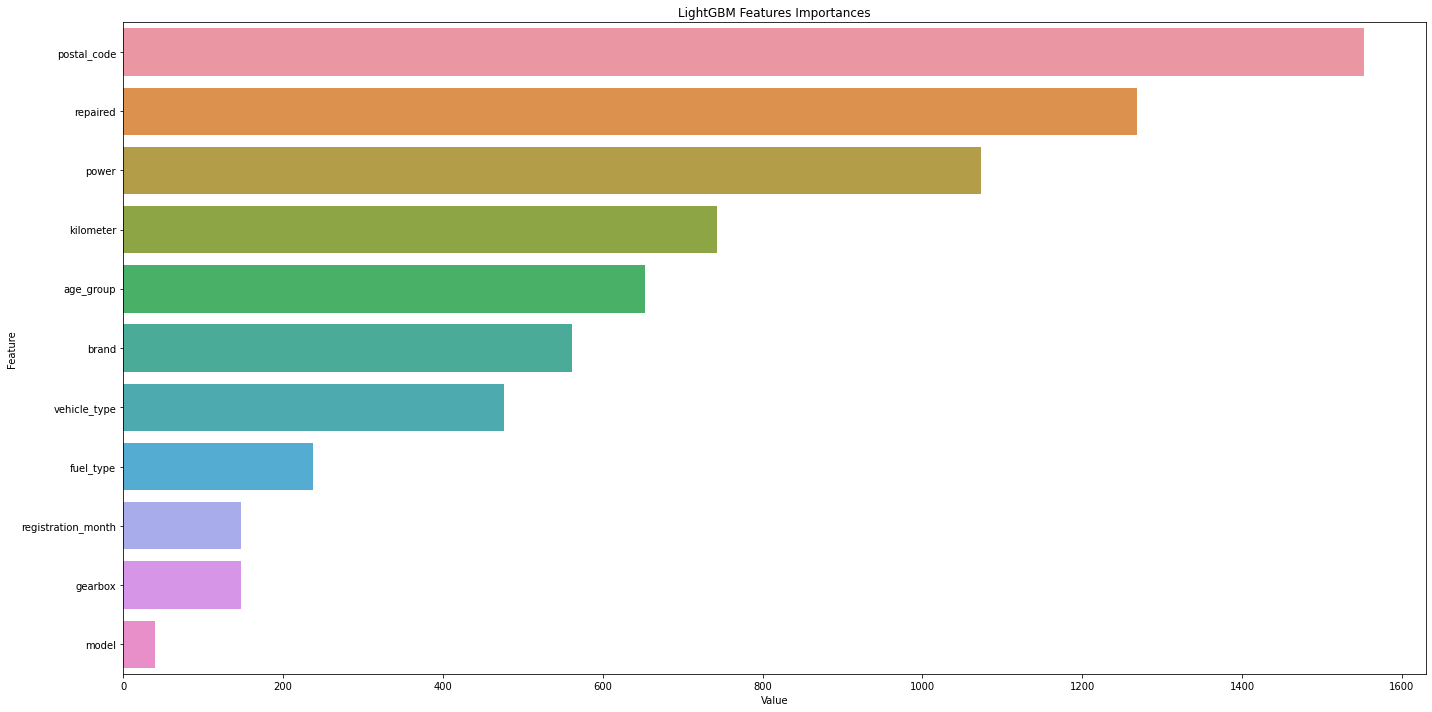

In [45]:
# обучим лучшую по метрике RMSE модель LGBMRegressor и построим график feature_importance
model_LGBM = LGBMRegressor(random_state=12345, num_leaves=70, learning_rate=0.1).fit(x_test
                                                                                     , y_test)

feature_imp = pd.DataFrame(sorted(zip(model_LGBM.feature_importances_, x_test.columns))
                           , columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features Importances')
plt.tight_layout()
plt.show()

Больше всего на стоимость автомобиля влияет модель автомобиля, страна, ремонт. 

## Общие выводы

В датафрейме data 354369 записей, названия столбцов адекватны содержащимся в них данным. Названия столбцов были отредактированы. Было проверено, нет ли пропущенных значений, для категориальных данных пропуски заменены на unknown. Было проверено наличие явных и неявных дубликатов, 4 дубликата были удалены. Отдельно рассмотрены числовые и категориальные данные. Цена меняется от нуля до 20 тысяч, а медианное значение составляет примерно 2700. Возможно, нулевые значения являются ошибкой в данных и их можно удалить. Удалены записи с registration_year до 1900 года и после 2016. Мощности автомобилей в данных меняются от нуля до 20 000 л.с, часть данных явно ошибочно заполнена, удалены записи с мощность более 1000. В столбце тип топлива gasoline переименовали petrol. Столбцы date_crawled, date_created, last_see, number_of_pictures никак не влияют на стоимость автомобиля, поэтому было принято решение удалить столбцы. Данные готовы к обучению моделей.

Для LinearRegression RMSE - 2845, для модели DecisionTreeRegressor при max_depth 11 RMSE - 2601, для модели RandomForestRegressor при max_depth 11 - 2475, для LGBM 'learning_rate': 0.1, 'num_leaves': 70 RMSE - 2348.

У LinearRegression время обучения 24.3 секунд, предсказание на тренировочной выборке - 265 мсек, у DecisionTreeRegression время обучения - 723 мсек, предсказание на тренировочной выборке - 20.1 мсек, у RandomForestRegression время обучения - 29 сек, предсказание на тренировочной выборке - 14.2 секунд, у LGBMRegressor время обучения 5.77 сек, предсказание на тренировочной выборке - 1.49 секунд. Самая быстрая по времени обучения и предсказания - LGBMRegressor. Наилучшая модель - LGBMRegressor (learning_rate=0.1, num_leaves=70).  Больше всего на стоимость автомобиля влияет модель автомобиля, страна, ремонт.

## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнена загрузка и подготовка данных
- [x]  Выполнено обучение моделей
- [x]  Есть анализ скорости работы и качества моделей